In [ ]:
pip install InstagramAPI

     |████████████████████████████████| 522kB 7.3MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 133kB 13.7MB/s 
     |████████████████████████████████| 3.3MB 14.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for InstagramAPI: filename=InstagramAPI-1.0.2-cp37-none-any.whl size=14021 sha256=eeb3c27cf16b28588db38da19c5b8f15b73e6d8a390fa650873ca3e89c36b6ee
  Stored in directory: /root/.cache/pip/wheels/6c/00/8f/ff713f248704d409ad2c2fc1352ce62b2b4d7d12a75267a911
  Created wheel for imageio: filename=imageio-2.1.2-cp37-none-any.whl size=3248800 sha256=0525865c3c4d20e21a652ec99c771763c379e6edb34cfd4dac08fc4461a0efa5
  Stored in directory: /root/.cache/pip/wheels/46/d7/61/fe435bf3dc20403ff38ffed213528ae710b4301ac6b403c582
Successfully built InstagramAPI imageio
ERROR: tensorflow-datasets 4.0.1 has requirement requests>=2.19.0, but you'll have requests 2.11.1 which is incompatible.
ERROR: tensorboard 2.4.1 has re

In [ ]:
from InstagramAPI import InstagramAPI
import pandas as pd
import time
from pandas.io.json import json_normalize

In [ ]:
def login_to_instagram(username, password):
    api = InstagramAPI(username, password)
    api.login()
    
    return api

api = login_to_instagram('babi__0011','**********')

Request return 405 error!
{'message': '', 'status': 'fail'}
Request return 404 error!
Login success!



In [ ]:
def get_my_posts(api):
    '''Retrieve all posts from own profile'''
    my_posts = []
    has_more_posts = True
    max_id= ''

    while has_more_posts:
        api.getSelfUserFeed(maxid=max_id)
        if api.LastJson['more_available'] is not True:
            has_more_posts = False #stop condition

        max_id = api.LastJson.get('next_max_id','')
        my_posts.extend(api.LastJson['items']) #merge lists
        time.sleep(2) # slows down to avoid flooding

        if has_more_posts:
            print(str(len(my_posts)) + ' posts retrieved so far...')

    print('Total posts retrieved: ' + str(len(my_posts)))
    
    return my_posts

my_posts = get_my_posts(api)

Total posts retrieved: 3


In [ ]:
def get_posts_likers(api, my_posts):
    '''Retrieve all likers on all posts'''
    
    likers = []
    
    print('wait %.1f minutes' % (len(my_posts)*2/60.))
    for i in range(len(my_posts)):
        m_id = my_posts[i]['id']
        api.getMediaLikers(m_id)
        
        likers += [api.LastJson]
        
        # Include post_id in likers dict list
        likers[i]['post_id'] = m_id
        
        time.sleep(2)
    print('done')
    
    return likers

a=get_posts_likers(api,my_posts)

wait 0.1 minutes
done


In [ ]:
def get_posts_commenters(api, my_posts):
    '''Retrieve all commenters on all posts '''
    
    commenters = []
    
    print('wait %.1f minutes' % (len(my_posts)*2/60.))
    for i in range(len(my_posts)):
        m_id = my_posts[i]['id']
        api.getMediaComments(m_id)
        
        commenters += [api.LastJson]
        
        # Include post_id in commenters dict list
        commenters[i]['post_id'] = m_id
            
        time.sleep(2)
    print('done')
    
    return commenters

commenters = get_posts_commenters(api, my_posts)

wait 0.1 minutes
done


In [ ]:
def posts_likers_to_df(likers):
    '''Transforms likers list of dicts into pandas DataFrame'''
    
    # Normalize likers by getting the 'users' list and the post_id of each like
    df_likers = json_normalize(likers, 'users', ['post_id'])
    
    # Add 'content_type' column to know the rows are likes
    df_likers['content_type'] = 'like'
    
    return df_likers

def posts_commenters_to_df(commenters):
    '''Transforms commenters list of dicts into pandas DataFrame'''
    
    # Include username and full_name of commenter in 'comments' list of dicts
    for i in range(len(commenters)):
        if len(commenters[i]['comments']) > 0: # checks if there is any comment on the post
            for j in range(len(commenters[i]['comments'])):
                # Puts username/full_name one level up
                commenters[i]['comments'][j]['username'] = commenters[i]['comments'][j]['user']['username']
                commenters[i]['comments'][j]['full_name'] = commenters[i]['comments'][j]['user']['full_name']
                
    # Create DataFrame
    # Normalize commenters to have 1 row per comment, and gets 'post_id' from parent 
    df_commenters = json_normalize(commenters, 'comments', 'post_id')
    
    
    return df_commenters

df_likers = posts_likers_to_df(a)
df_commenters = posts_commenters_to_df(commenters)

In [ ]:
print('Total posts: ' + str(len(my_posts)))
print('---------')
print('Total likes on profile: ' + str(df_likers.shape[0])) #shape[0] represents number of rows
print('Distinct users that liked your posts: ' +str(df_likers.username.nunique())) # nunique() will count distinct values of a col
print('---------')
print('Total comments on profile: ' + str(df_commenters.shape[0]))
print('Distinct users that commented your posts: ' +str(df_commenters.username.nunique()))

Total posts: 3
---------
Total likes on profile: 32
Distinct users that liked your posts: 19
---------
Total comments on profile: 2
Distinct users that commented your posts: 2


In [ ]:
df_likers.username.value_counts()[:10]

hanith_chowdary_      3
shanmukh02            3
deepak_ragidi         3
mohansaimanikanta     3
yogesh___0011         2
naga_durga_rao        2
preethi_dietitian     2
bhanuchandrapati07    2
gopichand._.kota      2
ehteshama672          1
Name: username, dtype: int64

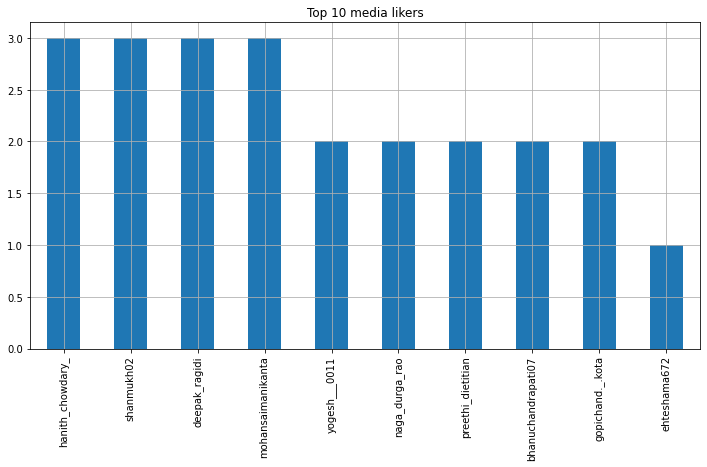

In [ ]:
df_likers.username.value_counts()[:10].plot(kind='bar', title='Top 10 media likers', grid=True, figsize=(12,6))

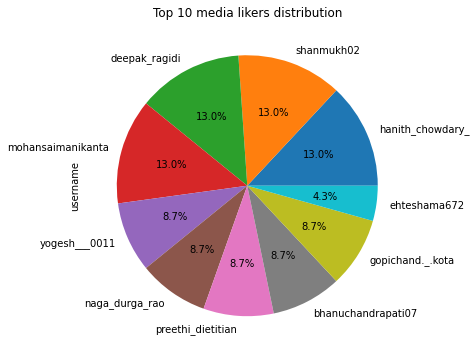

In [ ]:
df_likers.username.value_counts()[:10].plot(kind='pie', title='Top 10 media likers distribution', autopct='%1.1f%%', figsize=(12,6))

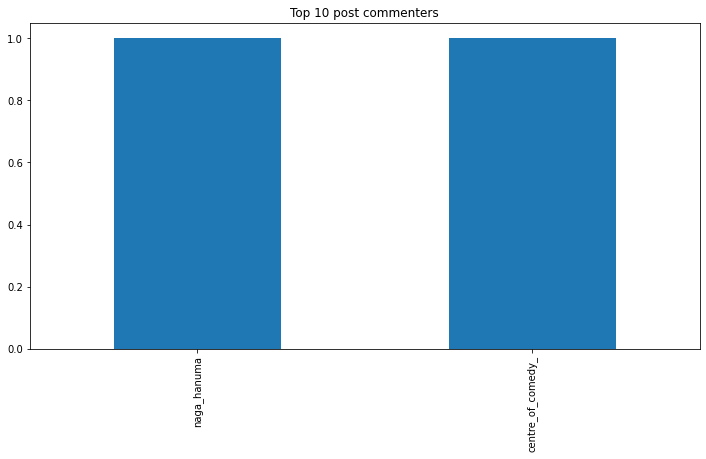

In [ ]:
df_commenters['username'].value_counts()[:10].plot(kind='bar', figsize=(12,6), title='Top 10 post commenters')